1.59639117396732 mars's
1.5679385733198765 earth's
[ 2.65037760e+10 -1.44729545e+11]
[ 2.65049236e+10 -1.44735812e+11]
crash launch


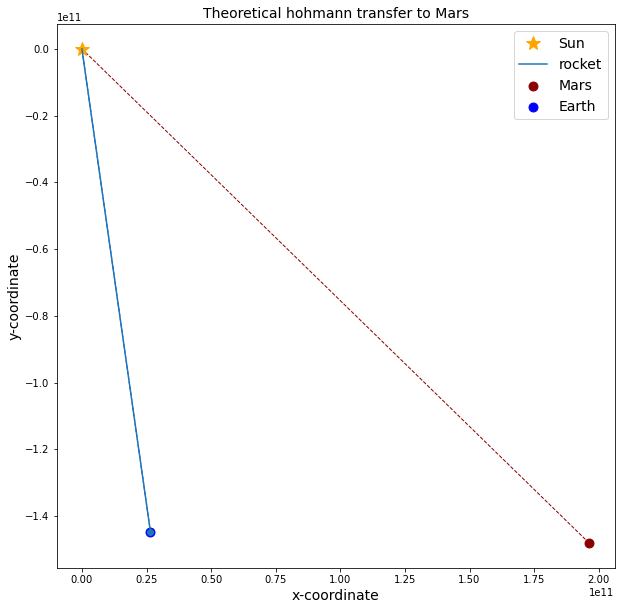

In [5]:
                        #optimise function, Only works for dt=200

import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.optimize import minimize
G = 6.6726e-11   #Grav constant
dt=200  #timestep size
n= 111802  # based on theorteical transfer time 
i=0 #for the loop later
PI=np.pi

class Planet:
    def __init__(self, name, mass, dist, radius, period,theta):
        self.name=name
        self.mass=mass
        self.dist=dist
        self.radius=radius
        self.period=period
        self.theta=theta  #
        self.pos=self.dist*np.array([np.cos(2*PI*dt*i/self.period+theta),np.sin(2*PI*dt*i/self.period+theta)])
        self.vel=np.array([0.0,0.0])
        #angular offset based on 28/07/2022   https://www.theplanetstoday.com/
        
class Satellite:
    def __init__(self, name, mass, pos):
        self.name=name
        self.mass=mass
        self.pos=pos
        self.vel=np.array([0,0])
        


 
def getAngle(a, b, c):
    ang = math.degrees(math.atan2(c[1]-b[1], c[0]-b[0]) - math.atan2(a[1]-b[1], a[0]-b[0]))
    return ang + 360 if ang < 0 else ang

def toUnit(v):
    norm = np.linalg.norm(v)
    if norm == 0: 
       return v
    return v / norm

def grav(pos, m1,m2,m3): #m1 is sun, m2 earth, m3 mars, m4 venus
    acc=np.array([0.0,0.0])
    r1=m1.pos-pos
    r2=m2.pos-pos
    r3=m3.pos-pos
    magr1=np.linalg.norm(r1)
    magr2=np.linalg.norm(r2)
    magr3=np.linalg.norm(r3)
    r11=toUnit(r1)
    r21=toUnit(r2)
    r31=toUnit(r3)
    acc1_mag= G*m1.mass/(magr1*magr1)
    acc2_mag= G*m2.mass/(magr2*magr2)
    acc3_mag= G*m3.mass/(magr3*magr3)
    acc[0]= acc1_mag*r11[0]+acc2_mag*r21[0]+acc3_mag*r31[0]
    acc[1]= acc1_mag*r11[1]+acc2_mag*r21[1]+acc3_mag*r31[1]
    return acc

def RK4_nbody(fly,m1,m2,m3,a):  #up to 4 bodies
    z1=fly.pos+(a/2)*fly.vel
    acc1=grav(fly.pos,m1,m2,m3) #need fly but with position z1
    v1=fly.vel+(a/2)*acc1
    z2=fly.pos+(a/2)*v1
    acc2=grav(z1,m1,m2,m3)   #need fly but with position z2
    v2=fly.vel+(a/2)*acc2
    z3=fly.pos+a*v2
    acc3=grav(z2,m1,m2,m3)
    v3=fly.vel+a*acc3
    fly.pos=fly.pos+(a/6)*(fly.vel+2*v1+2*v2+v3)
    acc4=grav(z3,m1,m2,m3)
    fly.vel= fly.vel+(a/6)*(acc1+2*acc2+2*acc3+acc4)
    
    
    
def objective(V):  #fixed dt=200 and starting positions of planets
    earth.pos=np.array([2.64620571e+10, -1.44737056e+11])
    earth.vel=np.array([29800.00195841, 5360.4657275 ])
    mars.pos=np.array([1.96292813e+11, -1.48131557e+11])
    mars.vel=np.array([12932.47050695, 18081.16402099])
    a=getAngle([0,-1], sun.pos,earth.pos)*PI/180 #angle between vertical and cun-earth line, need to know where the rocket launch is optimal
    spinvelocity=earth.radius/earth.period*2*PI
    rocket = Satellite("rocket", 2.8e+6,np.array([earth.pos[0]+np.sin(a)*earth.radius,earth.pos[1]-np.cos(a)*earth.radius]))
    rocket.vel=np.array([earth.vel[0]+np.cos(a)*spinvelocity, earth.vel[1]+np.sin(a)*spinvelocity])

    #input vector delat V, the additional velocity
    rocket.vel = rocket.vel+V
    for i in range(0,n):
        RK4_nbody(earth,sun,mars,rocket,dt)
        RK4_nbody(mars,sun,rocket,earth,dt)
        RK4_nbody(rocket,sun,earth,mars,dt) #200 is dt
    distt=rocket.pos-mars.pos
    return np.linalg.norm(distt)  #works!
    
    
def My_Minimizer(fun, start, step):    #doesnt work yet
    bit=1 #bit 1 means keep running, 0 means break
    token=0 #0 means flip the x, 1 means flip y
    trial=0
    roulette=0 # determines the method of itteration
    benchmark= fun(start)
    x=np.array([start[0],start[1]])
    tempx=np.array([start[0],start[1]])
    while bit==1:
        trial+=1
        tempx= np.copy(x)
        tempx[token]+=step
        funn=fun(tempx)
        if funn < benchmark:
            roulette=0
            x=np.copy(tempx)
            benchmark=funn
            print("so far ", x, benchmark)
        else:
            if roulette==0: #first failiure, try changing the other component.
                print('trying changing other component instead')
                if token==1:
                    token=0
                else:
                    token=1
            if roulette==1: #second failiure, move the other way
                step=step*(-1)
                print('try negative steps')
            if roulette==2: #third failiure, change the other component and go the other way
                if token==1:
                    token=0
                else:
                    token=1
                print('try changing the first component again')
            if roulette==3: #fourth failiure, halve the step size and go to step 1 again and flip token
                roulette-=4
                step=step/2
                print("halving event")
            roulette+=1
        
        #exiting the code at the number of wanted sf
        if abs(step) < 1:
            print("reached required S.F, smallest unit of accuracy=", step)
            print("required ", trial, " itterations")
            print("solution V=",x," and innacurracy = ", benchmark)
            bit=0

            
def minimizer(fun, xbounds, ybounds, nsteps):   #works
    xstep=(xbounds[1]-xbounds[0])/nsteps
    ystep=(ybounds[1]-ybounds[0])/nsteps
    best=10e+12
    minv=np.array([0,0])
    v=np.array([0,0])
    for i in range(0,nsteps):
        v[0]=i*xstep+xbounds[0]
        for k in range (0,nsteps):
            v[1]=k*ystep+ybounds[0]
            value= fun(v)
            print(v,value)
            if value<best:
                minv[0]=v[0]
                minv[1]=v[1]
                best=value
    print(minv, best)
    
def epsilon(POS,SPEED,m1,m2): #m1,m2,m3,m4 are sun,earth,mars,venus, k is i (which element of array pointer)
    EK=0.5*SPEED**2
    r1=m1.pos-POS
    r2=m2.pos-POS
    magr1=np.linalg.norm(r1)
    magr2=np.linalg.norm(r2)
    ham=EK-G*((m1.mass/magr1)+(m2.mass/magr2))
    return ham

earth = Planet("earth", 5.972e+24, 149.6e+9,6371000,3.154e+7,0) #period 3.154e+7 mass5.972e+24 
mars = Planet("mars",6.39e+23 , 227.94e+9, 3389500, 5.858e+7,0.7432802492995163)#theoretical angular offset 0.7432802492995163, period  59.4e+6   mass 6.39e+23
sun = Planet("sun", 1.99e+30, 0, 696340000, 31446925,0)

earth.pos=np.array([2.65037760e+10, -1.44729545e+11])
mars.pos=np.array([1.96310916e+11, -1.48106242e+11])
earth.vel=np.array([29798.45641053, 5368.91240079])
mars.vel=np.array([12930.01661753, 18083.01558064])
a=getAngle([0,-1], sun.pos,earth.pos)*PI/180
#angle between vertical and cun-earth line, need to know where the rocket launch is optimal
spinvelocity=earth.radius/earth.period*2*PI
rocket = Satellite("rocket", 0.0,np.array([earth.pos[0]+earth.radius*np.sin(a),earth.pos[1]-earth.radius*np.cos(a)]))
rocket.vel=np.array([earth.vel[0]+spinvelocity*np.cos(a), earth.vel[1]+spinvelocity*np.sin(a)])
#print(np.linalg.norm(earth.pos), "earth's pos")
#print(np.linalg.norm(earth.vel), "earth's vel")
#print(np.linalg.norm(mars.pos), "mars pos")
#print(np.linalg.norm(mars.vel), 'mars.vel')
vector_1 = mars.pos
vector_2 = mars.vel

unit_vector_1 = vector_1 / np.linalg.norm(vector_1)
unit_vector_2 = vector_2 / np.linalg.norm(vector_2)
dot_product = np.dot(unit_vector_1, unit_vector_2)
angle = np.arccos(dot_product)

print(angle, "mars's")
vector_1 = earth.pos
vector_2 = earth.vel

unit_vector_1 = vector_1 / np.linalg.norm(vector_1)
unit_vector_2 = vector_2 / np.linalg.norm(vector_2)
dot_product = np.dot(unit_vector_1, unit_vector_2)
angle = np.arccos(dot_product)
print(angle, "earth's")

PEX=np.zeros(n)
PEY=np.zeros(n)
PMX=np.zeros(n)
PMY=np.zeros(n)
RX=np.zeros(n)
RY=np.zeros(n)
#input vector delat V, the additional velocity   escape velocity 11110
V=np.array([10844.8, 3659.0])
rocket.vel = rocket.vel+V

print(earth.pos)
print(rocket.pos)
for i in range(0,n):
    
    RK4_nbody(earth,sun,rocket,mars,dt)
    RK4_nbody(mars,sun,earth,rocket,dt)
    RK4_nbody(rocket,sun,earth,mars,dt)
    RX[i]=rocket.pos[0]
    RY[i]=rocket.pos[1]
    PEX[i]=earth.pos[0]
    PEY[i]=earth.pos[1]
    PMX[i]=mars.pos[0]
    PMY[i]=mars.pos[1]
    if np.linalg.norm(earth.pos-rocket.pos)<earth.radius:
        print("crash launch")
        break
    if np.linalg.norm(rocket.pos-mars.pos)<mars.radius:
        print("mars crash")
        break


fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(111)
ax.plot(PMX,PMY, color="darkred", linewidth=1, linestyle="dashed" )
ax.plot(PEX,PEY, color="blue", linewidth=1, linestyle="dashed" )
ax.plot(0,0,label='Sun', marker="*", markersize=15, color="orange", linewidth=0)
ax.scatter(PMX[i],PMY[i], label="Mars", color="darkred", marker="o",s=80)
ax.scatter(PEX[i],PEY[i], label='Earth', color="blue", marker="o",s=80)
ax.plot(RX,RY, label='rocket')
ax.scatter(RX[i],RY[i])
ax.set_xlabel("x-coordinate",fontsize=14)
ax.set_ylabel("y-coordinate",fontsize=14)
ax.set_title("Theoretical hohmann transfer to Mars",fontsize=14)
ax.legend(loc="upper right",fontsize=14)

In [4]:
print(i)

0


In [87]:
print(i)

283


0.1808313019575294


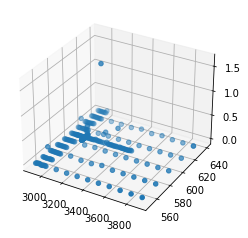

In [58]:
###making a 3d plot of the launch velocities
print(a)
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
fig = plt.figure()
ax = plt.axes(projection='3d')
ax = plt.axes(projection='3d')


with open('3ddata.txt') as f:
    lines = f.readlines()
    x = [line.split()[0] for line in lines]
    y = [line.split()[1] for line in lines]
    z = [line.split()[2] for line in lines]
xdata=np.array(x)
ydata=np.array(y)
zdata=np.array(z)
xdata=xdata.astype(float)
ydata=ydata.astype(float)
zdata=zdata.astype(float)

def zdata1(A,B):
    return A+B
zdata2=zdata1(xdata,ydata)

ax.scatter3D(xdata,ydata,zdata,  cmap=cm.coolwarm)
#ax.view_init(100, 0)

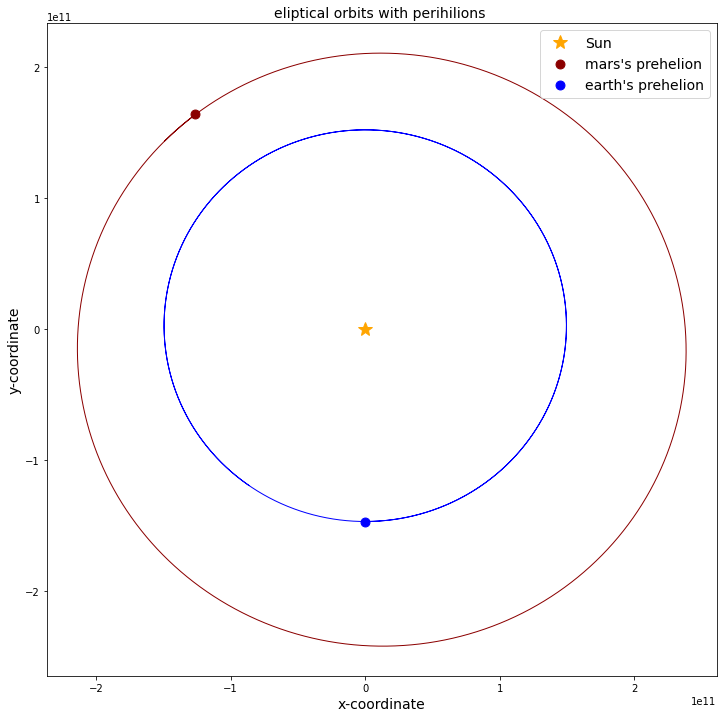

In [121]:
dt=200
n=300000
earth = Planet("earth", 5.972e+24 , 149.6e+9,6371000,3.154e+7,0) #period 3.154e+7
mars = Planet("mars", 6.39e+23, 227.94e+9, 3389500, 5.858e+7,0.7432802492995163)#theoretical angular offset 0.7432802492995163, period  59.4e+6
sun = Planet("sun", 1.99e+30, 0, 696340000, 31446925,0)

rocket = Satellite("rocket", 2.8e+6,np.array([earth.radius+earth.dist, 0]))
rocket.vel[1]=(((earth.dist+earth.radius)/earth.period)+(earth.radius/86400))*2*PI

#use planet's preheliopn positions and velocities as starting points  (−126, 169, 776, 453 m, 163, 625, 969, 530 m) (0 m, −147, 098, 074, 000 m)
mars.pos=np.array([-126169776453.0,163625969530.0])
earth.pos=np.array([0.0,147098074000.0*(-1)])
earth.vel=np.array([30286.0,0])

mars.vel=np.array([(mars.pos[1]/np.linalg.norm(mars.pos))*26449.0*(-1), 26449.0*mars.pos[0]/np.linalg.norm(mars.pos)])



PEX=np.zeros(n)
PEY=np.zeros(n)
PMX=np.zeros(n)
PMY=np.zeros(n)
RX=np.zeros(n)
RY=np.zeros(n)

for i in range(0,n):
    RK4_nbody(rocket,sun,earth,mars,dt)
    RK4_nbody(earth,sun,mars,rocket,dt)
    RK4_nbody(mars,sun,earth,rocket,dt)
    RX[i]=rocket.pos[0]
    RY[i]=rocket.pos[1]
    PEX[i]=earth.pos[0]
    PEY[i]=earth.pos[1]
    PMX[i]=mars.pos[0]
    PMY[i]=mars.pos[1]


fig=plt.figure(figsize=(12,12))
ax=fig.add_subplot(111)
ax.plot(PMX,PMY, color="darkred", linewidth=1)
ax.plot(PEX,PEY, color="blue", linewidth=1 )
ax.plot(0,0,label='Sun', marker="*", markersize=15, color="orange", linewidth=0)
#ax.scatter(PMX[i],PMY[i], label="Mars", color="darkred", marker="o",s=80)
#ax.scatter(PEX[i],PEY[i], label='Earth', color="blue", marker="o",s=80)
#ax.plot(RX,RY, label='rocket')
#ax.scatter(RX[i],RY[i])
ax.scatter(PMX[0],PMY[0], label="mars's prehelion", color="darkred", s=80)
ax.scatter(PEX[0],PEY[0], label="earth's prehelion", color="blue", s=80)
ax.set_xlabel("x-coordinate",fontsize=14)
ax.set_ylabel("y-coordinate",fontsize=14)
ax.set_title("eliptical orbits with perihilions ",fontsize=14)
ax.legend(loc="upper right",fontsize=14)


In [117]:
print(getAngle(earth.pos,sun.pos,mars.pos))#42.58682128029395

42.589993497459346


In [69]:
print(0.7432802492995163*180/PI)

42.586821280293954


[-0.33851694  0.35087287  0.56193784  0.56215333  0.70736825  0.56803562
  0.94921246 -0.36032585 -1.08480182 -0.62472281 -0.86328311 -0.23616632
  0.86083983  0.17277341  0.79180555 -0.76233033 -0.5377603   0.32473894
 -0.02041333  0.47029048  0.51692097  0.9275729  -0.93190104  0.62635397
  0.20553559 -0.64674688 -0.7044767   1.00591947 -0.59908591  1.0112816
 -0.92325828  1.0330296   0.67202665 -0.9127041   0.31963219 -0.9167549
  0.0270235   1.07134039  0.61178354 -0.95388447  0.74805138 -0.8685439
  0.43074297 -0.82564955  0.42935655 -0.98627694 -0.78491455  0.93131859
  0.22220272  0.12985894]


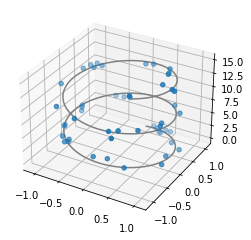

In [174]:
# Data for a three-dimensional line
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
fig = plt.figure()
ax = plt.axes(projection='3d')
ax = plt.axes(projection='3d')

zline = np.linspace(0, 15, 1000)
xline = np.sin(zline)
yline = np.cos(zline)
ax.plot3D(xline, yline, zline, 'gray')

# Data for three-dimensional scattered points
zdata = 15 * np.random.random(50)
xdata = np.sin(zdata) + 0.1 * np.random.randn(50)
ydata = np.cos(zdata) + 0.1 * np.random.randn(50)
ax.scatter3D(xdata, ydata, zdata);
print(xdata)

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.optimize import minimize
G = 6.6726e-11   #Grav constant
dt=200  #timestep size
n= 111802  # based on theorteical transfer time 
i=0 #for the loop later
PI=np.pi

class Planet:
    def __init__(self, name, mass, dist, radius, period,theta):
        self.name=name
        self.mass=mass
        self.dist=dist
        self.radius=radius
        self.period=period
        self.theta=theta  #
        self.pos=self.dist*np.array([np.cos(2*PI*dt*i/self.period+theta),np.sin(2*PI*dt*i/self.period+theta)])
        self.vel=np.array([0.0,0.0])
        #angular offset based on 28/07/2022   https://www.theplanetstoday.com/
        
class Satellite:
    def __init__(self, name, mass, pos):
        self.name=name
        self.mass=mass
        self.pos=pos
        self.vel=np.array([0,0])
        


 
def getAngle(a, b, c):
    ang = math.degrees(math.atan2(c[1]-b[1], c[0]-b[0]) - math.atan2(a[1]-b[1], a[0]-b[0]))
    return ang + 360 if ang < 0 else ang

def toUnit(v):
    norm = np.linalg.norm(v)
    if norm == 0: 
       return v
    return v / norm

def grav(pos, m1,m2,m3): #m1 is sun, m2 earth, m3 mars, m4 venus
    acc=np.array([0.0,0.0])
    r1=m1.pos-pos
    r2=m2.pos-pos
    r3=m3.pos-pos
    magr1=np.linalg.norm(r1)
    magr2=np.linalg.norm(r2)
    magr3=np.linalg.norm(r3)
    r11=toUnit(r1)
    r21=toUnit(r2)
    r31=toUnit(r3)
    acc1_mag= G*m1.mass/(magr1*magr1)
    acc2_mag= G*m2.mass/(magr2*magr2)
    acc3_mag= G*m3.mass/(magr3*magr3)
    acc[0]= acc1_mag*r11[0]+acc2_mag*r21[0]+acc3_mag*r31[0]
    acc[1]= acc1_mag*r11[1]+acc2_mag*r21[1]+acc3_mag*r31[1]
    return acc

def RK4_nbody(fly,m1,m2,m3,a):  #up to 4 bodies
    z1=fly.pos+(a/2)*fly.vel
    acc1=grav(fly.pos,m1,m2,m3) #need fly but with position z1
    v1=fly.vel+(a/2)*acc1
    z2=fly.pos+(a/2)*v1
    acc2=grav(z1,m1,m2,m3)   #need fly but with position z2
    v2=fly.vel+(a/2)*acc2
    z3=fly.pos+a*v2
    acc3=grav(z2,m1,m2,m3)
    v3=fly.vel+a*acc3
    fly.pos=fly.pos+(a/6)*(fly.vel+2*v1+2*v2+v3)
    acc4=grav(z3,m1,m2,m3)
    fly.vel= fly.vel+(a/6)*(acc1+2*acc2+2*acc3+acc4)
    
    
    
def objective(V):  #fixed dt=200 and starting positions of planets
    earth.pos=np.array([2.64620571e+10, -1.44737056e+11])
    earth.vel=np.array([29800.00195841, 5360.4657275 ])
    mars.pos=np.array([1.96292813e+11, -1.48131557e+11])
    mars.vel=np.array([12932.47050695, 18081.16402099])
    a=getAngle([0,-1], sun.pos,earth.pos)*PI/180 #angle between vertical and cun-earth line, need to know where the rocket launch is optimal
    spinvelocity=earth.radius/earth.period*2*PI
    rocket = Satellite("rocket", 2.8e+6,np.array([earth.pos[0]+np.sin(a)*earth.radius,earth.pos[1]-np.cos(a)*earth.radius]))
    rocket.vel=np.array([earth.vel[0]+np.cos(a)*spinvelocity, earth.vel[1]+np.sin(a)*spinvelocity])

    #input vector delat V, the additional velocity
    rocket.vel = rocket.vel+V
    for i in range(0,n):
        RK4_nbody(earth,sun,mars,rocket,dt)
        RK4_nbody(mars,sun,rocket,earth,dt)
        RK4_nbody(rocket,sun,earth,mars,dt) #200 is dt
    distt=rocket.pos-mars.pos
    return np.linalg.norm(distt)  #works!

earth = Planet("earth", 5.972e+24, 149.6e+9,6371000,3.154e+7,0) #period 3.154e+7 mass5.972e+24 
mars = Planet("mars",6.39e+23 , 227.94e+9, 3389500, 5.858e+7,0.7432802492995163)#theoretical angular offset 0.7432802492995163, period  59.4e+6   mass 6.39e+23
sun = Planet("sun", 1.99e+30, 0, 696340000, 31446925,0)

earth.pos=np.array([2.65037760e+10, -1.44729545e+11])
mars.pos=np.array([1.96310916e+11, -1.48106242e+11])
earth.vel=np.array([29798.45641053, 5368.91240079])
mars.vel=np.array([12930.01661753, 18083.01558064])
a=getAngle([0,-1], sun.pos,earth.pos)*PI/180
#angle between vertical and cun-earth line, need to know where the rocket launch is optimal
spinvelocity=earth.radius/earth.period*2*PI
rocket = Satellite("rocket", 0.0,np.array([earth.pos[0]+earth.radius*np.sin(a),earth.pos[1]-earth.radius*np.cos(a)]))
rocket.vel=np.array([earth.vel[0]+spinvelocity*np.cos(a), earth.vel[1]+spinvelocity*np.sin(a)])

from scipy.optimize import minimize  
x0=[3045.4, 600]
minimize(objective, x0)

      fun: 21463843707.58389
 hess_inv: array([[ 3.55911424e-14, -4.82104250e-13],
       [-4.82104250e-13,  6.54373532e-12]])
      jac: array([1.01161984e+08, 1.28767488e+08])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 269
      nit: 3
     njev: 83
   status: 2
  success: False
        x: array([3045.38063813,  599.98035799])

In [ ]:
#[3045.38063813,  599.98035799]